### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/augmented/'

### Read augmented images from folder

In [2]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    rawy.append(int(file.split('_')[1]))

In [3]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [4]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h*im_w)
print(x.shape)
print(y.shape)

(12000, 10000)
(12000,)


In [5]:
rawx= None
rawy= None

In [6]:
x = x / 255.

In [7]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([2000, 2000, 2000, 2000, 2000, 2000], dtype=int64))

### Create train/test set

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [9]:
x = None
y = None

### Check how the images looks like

In [10]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)-1) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

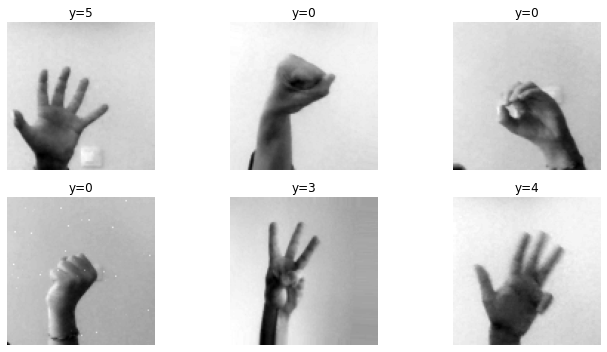

In [11]:
plot_6_images(xtrain,ytrain)

### Images are 100*100, perform PCA to reduce dimension perserving most of the variance

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
%time X_reduced = pca.fit_transform(xtrain)

Wall time: 7min 54s


In [13]:
print('dimension reduction from %d to %d after PCA preserving 99%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 10000 to 369 after PCA preserving 99% of variance


### Check how the images look like after PCA

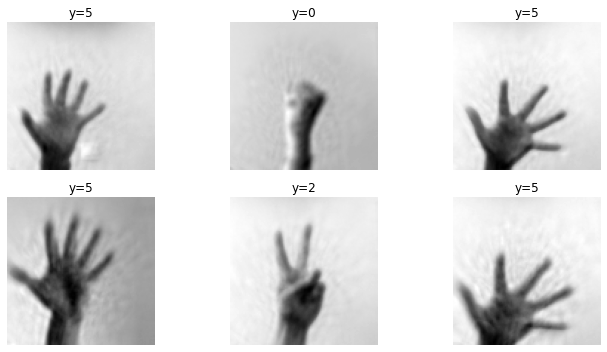

In [14]:
images = pca.inverse_transform(X_reduced)
plot_6_images(images,ytrain)

### Train different classifiers using default parameters

In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

classifs = [
           SGDClassifier(), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               ]

for name, clf in zip(classif_names, classifs):
    %time score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    print("%s : %s Score :" % (name,score), " Worst: %.4f" % score.min())

Wall time: 5.37 s
SGD		 : [0.714375 0.7025   0.673125] Score :  Worst: 0.6731
Wall time: 10.7 s
KNN		 : [0.875625  0.8796875 0.873125 ] Score :  Worst: 0.8731
Wall time: 6.45 s
DecisionTree	 : [0.714375  0.7053125 0.715625 ] Score :  Worst: 0.7053
Wall time: 58.7 s
SVC		 : [0.855625  0.8603125 0.8596875] Score :  Worst: 0.8556
Wall time: 24.7 s
RandomForest	 : [0.85875   0.85125   0.8634375] Score :  Worst: 0.8512


### RanfomForest looks promising, finetune it using gridsearch 

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'bootstrap':[True,False],
        'n_estimators':[10,50,100,],
        'max_features':[5,10,'auto'],
        'max_depth':[5,10,None],
    }
]

clf = RandomForestClassifier(random_state=37)
grid_search_rf = GridSearchCV(clf,param_grid,cv=3,return_train_score=True,verbose=1)
%time grid_search_rf.fit(X_reduced,ytrain);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  7.8min finished


Wall time: 8min 10s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=37,
                                  

In [17]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
0.8786458333333332


### Check accuracy on test dataset

In [18]:
from sklearn.model_selection import cross_val_predict

Xtest_reduced = pca.transform(xtest)
ytest_pred = cross_val_predict(grid_search_rf.best_estimator_,Xtest_reduced,ytest,cv=3)
score = grid_search_rf.best_estimator_.score(Xtest_reduced, ytest)*100

print("Model score: %.2f%% on test dataset (%d obs)" % (score,len(ytest)))

Model score: 90.00% on test dataset (2400 obs)


### Check confusion matrix

In [20]:
import pandas as pd

pd.crosstab(ytest, ytest_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,340,29,4,6,17,4,400
1,34,318,17,14,10,7,400
2,14,50,290,19,20,7,400
3,14,27,24,276,41,18,400
4,21,21,10,43,285,20,400
5,13,17,15,22,19,314,400
All,436,462,360,380,392,370,2400


### Showing on a graph only differences (relative values) 

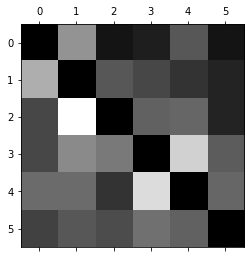

In [23]:
from sklearn.metrics import confusion_matrix

confmatr = confusion_matrix(ytest, ytest_pred)
row_sums = confmatr.sum(axis=1,keepdims=True)
norm_conf_matr = confmatr / row_sums
np.fill_diagonal(norm_conf_matr,0)
plt.matshow(norm_conf_matr,cmap=plt.cm.gray);

### Save model. (PCA has to be saved also to apply same transformation for future predictions)

In [24]:
import pickle

filename = 'model_classic.sav'
pickle.dump(grid_search_rf.best_estimator_, open(filename, 'wb'))

filename = 'model_classic_pca.sav'
pickle.dump(pca, open(filename, 'wb'))

### Try our model on a never seen before picture (original one)

In [25]:
import pickle
import os
import random
import cv2
import matplotlib.pyplot as plt
im_h,im_w=100,100
filename = 'model_classic.sav'
loaded_model = pickle.load(open(filename, 'rb'))

filename = 'model_classic_pca.sav'
loaded_pca = pickle.load(open(filename, 'rb'))

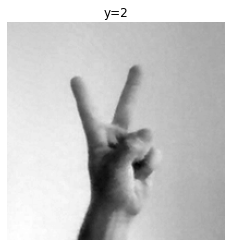

In [26]:
files = os.listdir('../data/originals/')
idx = random.randint(0,len(files)-1)
origimg = cv2.imread('../data/originals/'+files[idx],cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h* im_w)

xpca = loaded_pca.transform(myimg)

result = loaded_model.predict(xpca)
pred = result[0]

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');